In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

/home/taiger/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import utils
from model import RPN

In [3]:
np.random.seed(1)
tf.set_random_seed(1)

In [4]:
mnist = input_data.read_data_sets('data/', one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
n_crops = np.random.randint(1, 5)
n_crops

2

(array([9, 9]), array([[108, 156, 124, 190],
        [157, 130, 190, 163]]))

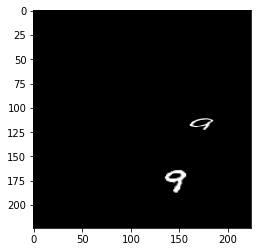

In [6]:
# use [y1, x1, y2, x2] as per original R-CNN trilogy
def make_crop(image):
    scale = np.random.uniform(0.5, 1.5, size=[2])
    w, h = (scale * 28).astype(np.int64)
    x = np.random.randint(image.shape[1] - w)
    y = np.random.randint(image.shape[0] - h)
    return y, x, y+h, x+w

def add_crop(image):
    crop, label = mnist.train.next_batch(1)
    crop = crop.reshape([28, 28])

    y1, x1, y2, x2 = make_crop(image)
    crop = cv2.resize(crop, (x2-x1, y2-y1))

    image[y1:y2, x1:x2] = crop
    return int(label), [y1, x1, y2, x2]

image = np.zeros([224, 224], np.float32)
gt_cls, gt_boxes = zip(*[add_crop(image) for i in range(n_crops)])
gt_cls, gt_boxes = map(np.array, (gt_cls, gt_boxes))

plt.imshow(image, cmap='gray')
gt_cls, gt_boxes

In [7]:
tf.reset_default_graph()
model = RPN()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    anchors, labels, mappings, loss = sess.run([model.anchors, model.labels, model.mappings, model.loss], feed_dict={
        model.images: image.reshape([1, 224, 224, 1]),
        model.gt_boxes: gt_boxes
    })
anchors.shape, labels.shape, mappings.shape

((6000, 4), (6000,), (6000,))

In [8]:
loss

3.1016152

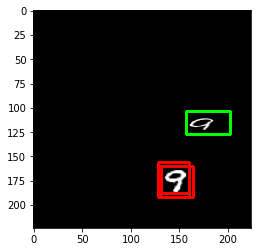

In [9]:
out = cv2.merge([(image * 255).astype(np.uint8)] * 3)
for idx in np.where(labels == 1)[0]:
    y1, x1, y2, x2 = map(int, anchors[idx])
    gt_box = mappings[idx]
    color = [(0, 255, 0), (255, 0, 0)][gt_box]
    cv2.rectangle(out, (x1, y1), (x2, y2), color, 2)
plt.imshow(out);

In [10]:
np.where(labels == 1)

(array([  93,  441,  494, 1905]),)

In [11]:
np.unique(labels, return_counts=True)

(array([-1.,  0.,  1.], dtype=float32), array([4697, 1299,    4]))